# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import pickle
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
reviewDF = pd.read_pickle('../Dataset/AFR/reviewDF')

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [15]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
rLength = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    

100%|██████████| 100000/100000 [00:21<00:00, 4739.71it/s]


In [16]:
preprocessed_reviews[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college'

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

In [17]:
# Dataframe with review length as extra feature
Dataset = pd.DataFrame(
    {
        'Review': preprocessed_reviews,
        'Score' : reviewDF['Score']

    })
X = Dataset.iloc[:,:2].values
X = np.array(X[:,:1])
X = X.reshape(X.shape[0],)

In [18]:
# Save to file in the current working directory
def saveModel(fileName,model):
        with open(fileName, 'wb') as file:
            pickle.dump(model, file)

In [19]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [20]:
# Please write all the code with proper documentation
# Bow vectorization
from sklearn.preprocessing import StandardScaler
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)
X_tfidf = vectorizer.fit_transform(X)
top_features = vectorizer.get_feature_names()

# Standardization
std = StandardScaler(with_mean = False)
X_tfidf = std.fit_transform(X_tfidf)

### [5.2] Calulation of Co-occurrence matrix

In [18]:
# https://datascience.stackexchange.com/questions/40038/how-to-implement-word-to-word-co-occurence-matrix-in-python

import nltk
# nltk.download()
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

sentences = X #['i go to london', 'you do not go to london','but london goes to you']

vocab = set(top_features)         # set(word_tokenize(' '.join(sentences)))
# print('Vocabulary:\n',vocab,'\n')


token_sent_list = [word_tokenize(sen) for sen in sentences]
# print('Each sentence in token form:\n',token_sent_list,'\n')

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
k=2

for sen in tqdm(token_sent_list):
    for ii in range(len(sen)):
        try:
            if ii < k:
                c = Counter(sen[0:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            elif ii > len(sen)-(k+1):
                c = Counter(sen[ii-k::])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            else:
                c = Counter(sen[ii-k:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
        except KeyError:
            pass
# Having final matrix in dict form lets you convert it to different python data structures
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}
# display(co_occ)

In [4]:
co_occ = getModel('co-matrix.pkl')

In [5]:
# constructing co-occurance matrix with top 3000 tfidf features from the co_occ dictionary
co_vec = []
for key1 in co_occ:
    temp = []
    for key2 in co_occ:
        try:
            val = co_occ[key1][key2]
            temp.append(val)
        except KeyError:
            temp.append(0)
    co_vec.append(temp)
co_vec = np.array(co_vec)

### [5.3] Finding optimal value for number of components (n) to be retained.

In [26]:
# Applying truncated svd to co-occurance matrix
svd = TruncatedSVD(n_components=co_vec.shape[1]-1, n_iter=7, random_state=42)
svd.fit(co_vec) 

# cumulative sum of variance explained with [n] features
tsvd_var_ratios_cumsum = np.cumsum(svd.explained_variance_ratio_)

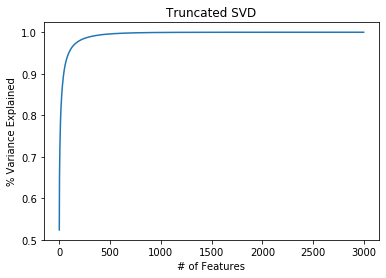

In [27]:
# plotting cumulative sum
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('Truncated SVD')
# plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(tsvd_var_ratios_cumsum)

#### Observation:
    - From the graph we can  observe that around 300 features are suffiecient to explain 99% of the total variance.

In [9]:
# Optimal n_components
optimal_n = 300

In [10]:
# Applying truncated svd to co-occurance matrix
svd = TruncatedSVD(n_components = optimal_n, n_iter=7, random_state=42)
feature_vec = svd.fit_transform(co_vec)

### [5.4] Applying k-means clustering


100%|██████████| 9/9 [00:05<00:00,  1.38it/s]No handles with labels found to put in legend.


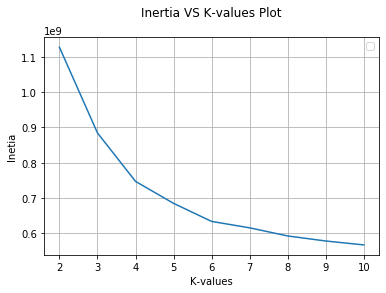

In [104]:
# Model Training
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia = []
for k in tqdm(n_clusters):
    model = KMeans(n_clusters=k, init='k-means++').fit(feature_vec)
    inertia.append(model.inertia_)

# plotting inertia vs k 
plt.legend()
plt.plot(n_clusters, inertia)
plt.xlabel('K-values')
plt.ylabel('Inetia')
plt.title('Inertia VS K-values Plot\n')
plt.grid()
plt.show()

From the graph we can see the influction point at k=6

### [5.5] Wordclouds of clusters obtained in the above section

In [99]:
optimal_K = 6
# KMeans++ with optimal value of K
kmeans = KMeans(n_clusters=optimal_K, init='k-means++').fit(feature_vec) 

# # adding label for each data point
# Dataset['Cluster_label'] = kmeans_bow.labels_

In [166]:
centroids = kmeans.cluster_centers_.argsort()

Cluster 0:

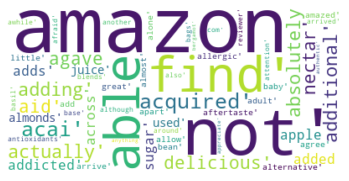

Cluster 1:

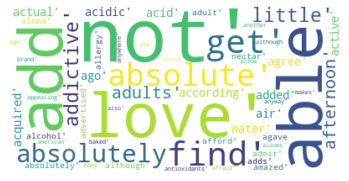

Cluster 2:

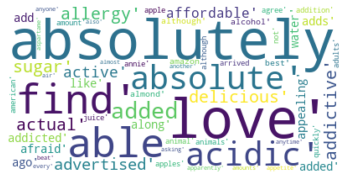

Cluster 3:

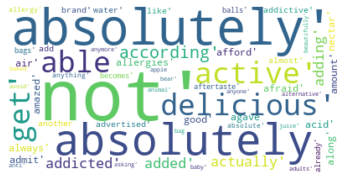

Cluster 4:

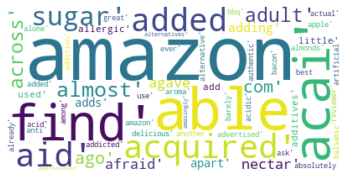

Cluster 5:

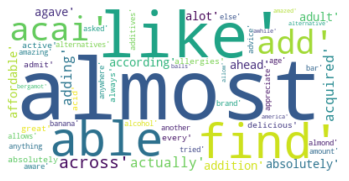

In [119]:
from wordcloud import WordCloud, STOPWORDS
stopwords_t = set(STOPWORDS)
centroids = kmeans.cluster_centers_.argsort()
terms = top_features
list1 = []
for i in range(len(kmeans.cluster_centers_.argsort())):
    print("Cluster %d:" % i, end='')
    # printing top 50 features 
    for j in centroids[i, :50]:
        list1.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list1)), stopwords=stopwords_t)
    wc.generate(str(list1))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list1.clear()

#### Observation:
    - Distinct clusters we can observe with truncated svd feature.

### [5.6] Function that returns most similar words for a given word.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
from scipy import spatial
import operator
def similarWord(word):
#     sim_words = []
    result={}
    if word not in top_features:
        print("Word not found!")
        return
    else:
        word_vec = feature_vec[top_features.index(word)]
        for i in range(len(top_features)):
            if word == top_features[i]:
                continue
            temp_vec = feature_vec[i]
            cos_sim = spatial.distance.cosine(word_vec, temp_vec)
            result[top_features[i]] = cos_sim
            
    sorted_results = sorted(result, key=result.get)[:10]
#     result.sort()
    return sorted_results#top_features[result.index(min(result))]

In [53]:
similarWord('best')

['bottle',
 'ask',
 'blended',
 'awhile',
 'agave nectar',
 'adults',
 'best thing',
 'beginning',
 'brother',
 'bread mix']

In [54]:
similarWord('test')

['awhile',
 'anytime',
 'celestial',
 'cases',
 'ask',
 'almost like',
 'bottle',
 'apples',
 'best thing',
 'adult']

In [55]:
similarWord("satisfied")

['best',
 'bbq',
 'addictive',
 'blue',
 'boxed',
 'brother',
 'brews',
 'burnt',
 'brew',
 'brown rice']

### custom co-occurance matrix as per the suggestion

In [2]:
Courpus =  ["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]
top_words = ["abc", "pqr", "def"]

In [3]:
# https://datascience.stackexchange.com/questions/40038/how-to-implement-word-to-word-co-occurence-matrix-in-python

import nltk
# nltk.download()
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

sentences = Courpus #['i go to london', 'you do not go to london','but london goes to you']

vocab = set(top_words)         # set(word_tokenize(' '.join(sentences)))
# print('Vocabulary:\n',vocab,'\n')


token_sent_list = [word_tokenize(sen) for sen in sentences]
# print('Each sentence in token form:\n',token_sent_list,'\n')

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
k=2

for sen in tqdm(token_sent_list):
    for ii in range(len(sen)):
        try:
            if ii < k:
                c = Counter(sen[0:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            elif ii > len(sen)-(k+1):
                c = Counter(sen[ii-k::])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
            else:
                c = Counter(sen[ii-k:ii+k+1])
                del c[sen[ii]]
                co_occ[sen[ii]] = co_occ[sen[ii]] + c
        except KeyError:
            pass
# Having final matrix in dict form lets you convert it to different python data structures
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}
# display(co_occ)

100%|██████████| 3/3 [00:00<00:00, 3345.63it/s]


In [7]:
# constructing co-occurance matrix with top 3000 tfidf features from the co_occ dictionary
co_vec = []
for key1 in co_occ:
    temp = []
    for key2 in co_occ:
        try:
            val = co_occ[key1][key2]
            temp.append(val)
        except KeyError:
            temp.append(0)
    co_vec.append(temp)
co_vec = np.array(co_vec)

In [8]:
co_vec

array([[0, 2, 3],
       [2, 0, 3],
       [3, 3, 0]])

In [ ]:
["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]

In [4]:
co_occ

{'pqr': {'def': 2, 'ijk': 1, 'klm': 1, 'opq': 1, 'lmn': 1, 'xyz': 1, 'abc': 3},
 'def': {'pqr': 2, 'abc': 3, 'ijk': 1, 'xyz': 1},
 'abc': {'def': 3, 'ijk': 1, 'pqr': 3, 'xyz': 1}}

# [6] Conclusions

#### Observation(s):
    - We were able to explain around 99% of variance with 300 latent features.
    - later when we performed clustering with these features, inflection point was observed at k=6 and formed cluster were very distinct.
    - Function to give similar word for a given word based on cosine similarity does not seems to be promising. 